In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
img = cv.imread('Sombreado.png',cv.IMREAD_GRAYSCALE)

In [3]:
# Funcion de binarización (a mano)
def global_threshold(image, thres_value, val_high, val_low):
    img = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] > thres_value:
                img[i,j] = val_high
            else:
                img[i,j] = val_low
    return img

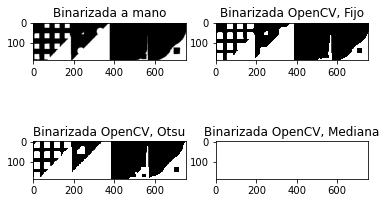

In [4]:
# Nueva figura
fig = plt.figure()

# Imagen binarizada (a mano - Fijo)
ax2=plt.subplot(221)
img_bin = global_threshold(img, 120, 1, 0);
ax2.imshow(img_bin,cmap='gray', vmin=0, vmax=1)
ax2.set_title('Binarizada a mano')

# Imagen binarizada (embebida - Fijo) - Parámetros: Imag_original,umbral,valor_máximo,método
ax3=plt.subplot(222)
ret, thresh = cv.threshold(img,120,255,cv.THRESH_BINARY)
ax3.imshow(thresh,cmap='gray', vmin=0, vmax=1)
ax3.set_title('Binarizada OpenCV, Fijo')

# Imagen binarizada (embebida - Otsu) - Parámetros: Imag_original,umbral,valor_máximo,método
ax4=plt.subplot(223)
ret, thresh = cv.threshold(img,120,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ax4.imshow(thresh,cmap='gray', vmin=0, vmax=1)
ax4.set_title('Binarizada OpenCV, Otsu')

# Imagen binarizada (embebida - Mediana) - Parámetros: Imag_original,valor_máximo,método adaptativo,tipo de umbral,tamaño de bloque,C
ax4=plt.subplot(224)
thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
ax4.imshow(thresh,cmap='gray', vmin=0, vmax=1)
ax4.set_title('Binarizada OpenCV, Mediana')

plt.show()

### Implementar 1: Búsqueda manual del umbral

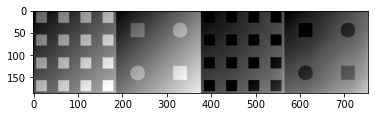

In [5]:
plt.imshow(img,cmap='gray')
plt.show()

In [6]:
# Ejercicio: Completar lo que falte y comparar contra el método de Otsu (por ejemplo restando las salidas)

#Paso1: Definir umbral inicial (en general la media de la imagen)

def buscar_umbral(img, umbral=128,delta_T=1.0):
    
    #Paso2: Dividir la imagen en dos partes
    # Usar np.where para encontrar los índices
    xp1,yp1= np.where(img < umbral)
    xp2,yp2= np.where(img > umbral)

    #Paso3: Encontrar la media de cada parte
    media_p1 = xp1.mean()
    media_p2 = xp2.mean()

    #Paso4: Calcular el nuevo umbral (promedio entre media anterior y actual)
    nuevo_umbral = media_p2 - media_p1

    #Paso5: Criterio de detención (o recalculo)
    if abs(nuevo_umbral-umbral)< delta_T:
        return nuevo_umbral
    else:
        return buscar_umbral(img, umbral=nuevo_umbral,delta_T=1.0)

In [7]:
umbral = buscar_umbral(img, umbral=128,delta_T=1.0)

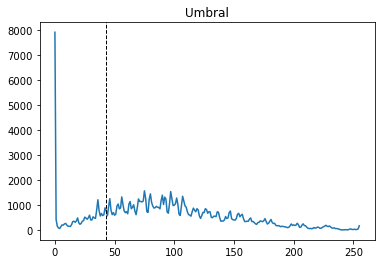

In [8]:
fig = plt.figure()

hist1,bins1 = np.histogram(img.ravel(),256,[0,256])
ax2=plt.subplot()
ax2.plot(hist1)
plt.axvline(umbral, color='k', linestyle='dashed', linewidth=1)
plt.title("Umbral")
fig.show()

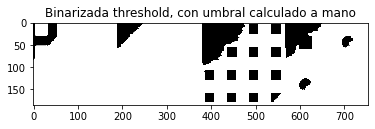

In [9]:
ret, img_umbral = cv.threshold(img,umbral,255,cv.THRESH_BINARY)
plt.imshow(img_umbral,cmap='gray', vmin=0, vmax=1)
plt.title('Binarizada threshold, con umbral calculado a mano')
plt.show()

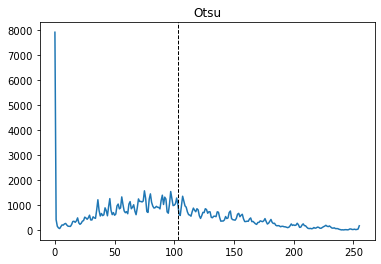

In [10]:
fig = plt.figure()
hist1,bins1 = np.histogram(img.ravel(),256,[0,256])
ax2=plt.subplot()
ax2.plot(hist1)
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_OTSU)
plt.axvline(ret2, color='k', linestyle='dashed', linewidth=1)
plt.title("Otsu")

fig.show()

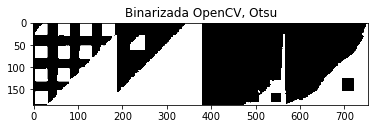

In [11]:
plt.imshow(th2,cmap='gray', vmin=0, vmax=1)
plt.title('Binarizada OpenCV, Otsu')
plt.show()

#### En los graficos del umbral encontrado por otsu y por la busca de umbral difiere mucho. Esto se debe a que el método Otsu presupone un histograma bimodal y una relación de contrastes alta entre el fondo y el objeto, dos cosas que en nuestra imagen (sin pensarla como 4 imagenes juntas) no sucede.

#### El algoritmo que diseñamos para hacerlo manualmente tampoco es muy útil ya que sigue siendo un método global, para objeter mejores resutlados se debe utilizar métodos locales.

### Implementar 2: Binarización local, método Bernsen

In [12]:
# Implementar para una ventana de 3x3, 5x5 o 7x7.
# Contraste: Máximo-Mínimo
# gris_medio: Media

In [78]:
def get_window_size(window):
    if window == 3:
        return 1
    if window == 5:
        return 2
    if window == 7:
        return 3

def bersen(img, window=3, contraste_referencia = 15):
    size = get_window_size(window)
    img_new = []
    for i in range(size, img.shape[0]):
        fila_new = []
        
        for j in range(size, img.shape[1]):
            local = img[i - size : i + size,j - size: j + size]
            contraste_local = local.max() - local.min()
            gris_medio = local.mean()
            gris_prmedio = (local.max() - local.min())/2
            
            if(contraste_local < contraste_referencia):
                pixel = 1 if (gris_medio >= 128) else  0
            else:
                pixel= 1 if (pixel >= gris_medio) else 0
            fila_new.append(pixel)
        img_new.append(fila_new)
        
    return img_new

Text(0.5, 1.0, 'Bernsen window = 5')

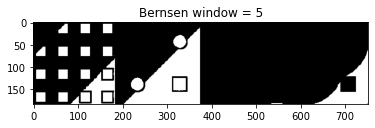

In [79]:
fig = plt.figure()
ax = plt.subplot()
ax.imshow(bersen(img, window=5),cmap='gray', vmin=0, vmax=1)
plt.title("Bernsen window = 5")

Text(0.5, 1.0, 'Bernsen window = 5')

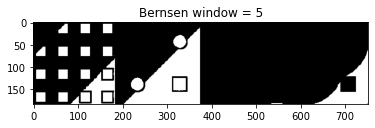

In [80]:
fig = plt.figure()
ax = plt.subplot()
ax.imshow(bersen(img, window=5),cmap='gray', vmin=0, vmax=1)
plt.title("Bernsen window = 5")

Text(0.5, 1.0, 'Bernsen window = 7')

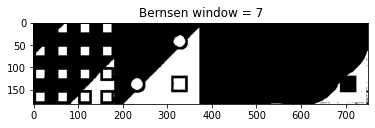

In [81]:
fig = plt.figure()
ax = plt.subplot()
ax.imshow(bersen(img, window=7),cmap='gray', vmin=0, vmax=1)
plt.title("Bernsen window = 7")

#### Se puede ver que al aumentar la ventana los bordes son mas "lisos" o menos pixelados. Esto es porque se toma en cuenta mas pixeles de la ventana "mas contexto"